In [1]:
%matplotlib inline

In [5]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import datasets
from torch.autograd import Variable
import numpy as np
import cv2
import torchvision.transforms.functional as trans
from matplotlib import pyplot as plt
from utils.augmentation import *
from utils.preprocessing import *
from PIL import Image

In [56]:
image_basic_transformation = transforms.Compose([
    transforms.Resize((48,48)),
    Imadjust(),
    transforms.ToTensor()
])

In [57]:
def plot_images(images_list, target_tensor):
    mapping = {
        0: "20Kph",
        1: "30Kph",
        2: "50Kph",
        3: "60Kph",
        4: "70Kph",
        5: "80Kph",
        6: "End 80Kph",
        7: "100Kph",
        8: "120Kph",
        9: "Yield",
        10: "Stop",
        11: "End All",
        12: "Unknown"
    }
    if images_list.dim() == 4:
        fig = plt.figure(figsize=(20, 7))
        rows = 1
        columns = len(images_list)
        for i, im in enumerate(images_list):
            im = im.swapaxes(0,1).swapaxes(1,2).numpy()
            fig.add_subplot(rows, columns, i+1)
            plt.title(mapping[target_tensor[i].data.item()])
            plt.imshow(im)
    elif images_list.dim() == 3:
        fig = plt.figure(figsize=(10, 10))
        rows = 1
        columns = 1
        im = images_list.swapaxes(0,1).swapaxes(1,2).numpy()
        fig.add_subplot(rows, columns, 1)
        plt.title(mapping[target_tensor.data.item()])
        plt.imshow(im)
    else:
        print("error in number of torch.dim() != 4 != 3")

In [5]:
# train_dataset = datasets.ImageFolder("data/train_images", transform=image_basic_transformation)
train_dataset = datasets.ImageFolder("data/val_images", transform=data_transforms)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

In [7]:
images, target = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


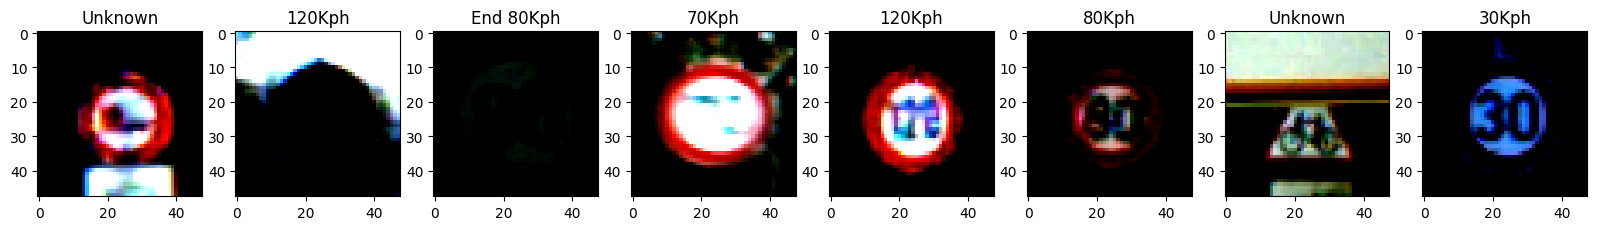

In [8]:
plot_images(images, target)

In [9]:
#plot_images(torch.concat([images[3].unsqueeze(0), (transforms.Normalize((0.3332, 0.3019, 0.3060), (0.2827, 0.2710, 0.2739))(images[3])).unsqueeze(0)]))

In [10]:
train_dataset_no_norm = datasets.ImageFolder("data/val_images", transform=image_basic_transformation)

In [11]:
train_loader_no_norm = torch.utils.data.DataLoader(train_dataset_no_norm, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

In [12]:
images, target = next(iter(train_loader_no_norm))

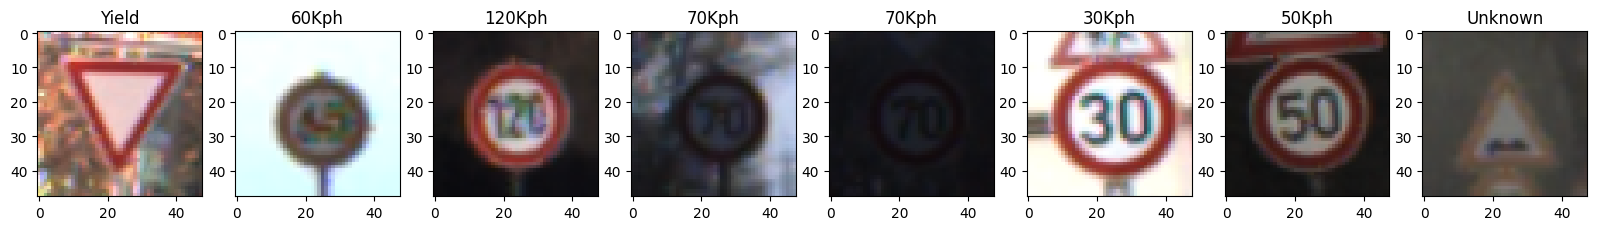

In [13]:
plot_images(images, target)

In [92]:
def show_color_hist(path):
    image = cv2.imread(path)
    # define colors to plot the histograms
    colors = ('b','g','r')
    # compute and plot the image histograms
    for i,color in enumerate(colors):
        hist = cv2.calcHist(image,[i],None,[256],[0,256])
        plt.plot(hist, color=color)
    plt.title('Color Histogram RGB')
    plt.show()

def show_lum_hist(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    hist = cv2.calcHist(image,[0],None,[256],[0,256])
    plt.plot(hist)
    plt.title('Luminosity Histogram LABSpace')
    plt.show()

def show_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

def adapthisteq(path, kernel=6):
    np_image = np.asarray(torchvision.transforms.Resize((48,48))(Image.open(path)))
    image = torch.from_numpy(np_image)
    image = image.swapaxes(1,2).swapaxes(0,1)

    assert image.shape[1] == image.shape[2], "Error in image transformation height and weight are not equal"

    iC, iH, iW = image.shape
    kH = kW = kernel

    oH = oW = iW // kW

    for i in range(oH):
        for j in range(oW):
            image[:, i*kH:i*kH+kH, j*kW:j*kW+kW] = trans.equalize(image[:, i*kH:i*kH+kH, j*kW:j*kW+kW])

    image = torchvision.transforms.ToPILImage()(image)
    return image

In [5]:
file = "data/val_images/00008/00008_00031_00022.ppm"

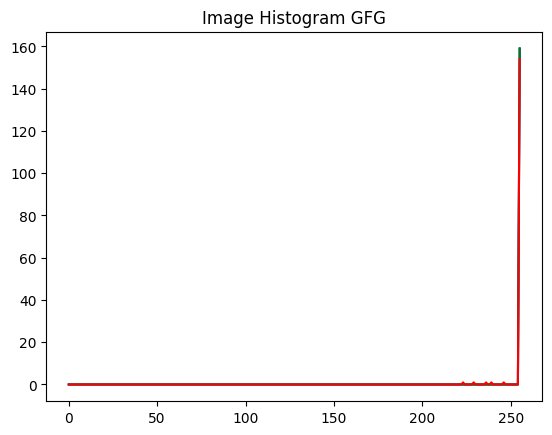

In [6]:
show_color_hist(file)

In [7]:
im = Image.open(file)
im = trans.adjust_contrast(im, 10)
im = im.save("prova.ppm")

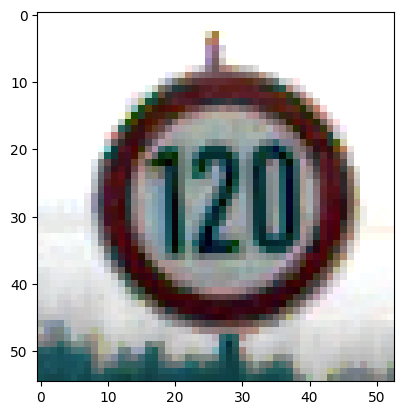

In [98]:
im = Image.open(file)
im = trans.equalize(im)
im = im.save("prova.ppm")
show_image("prova.ppm")

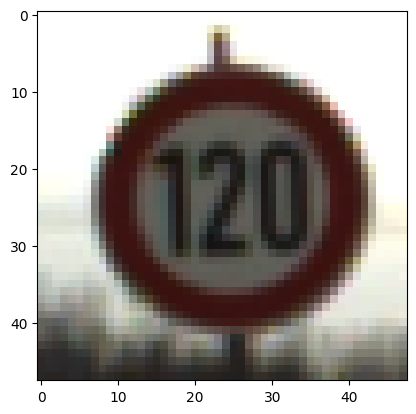

In [94]:
adapthisteq(file)
show_image("prova.ppm")

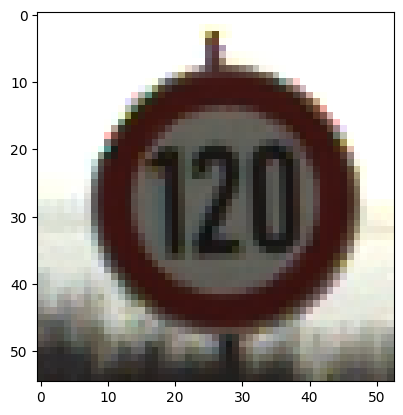

In [99]:
show_image(file)

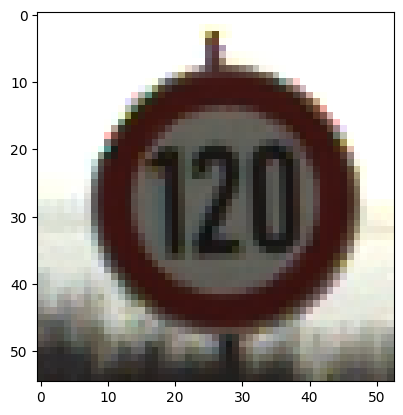

In [100]:
img = cv2.imread(file)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img, vmin=0, vmax=1)

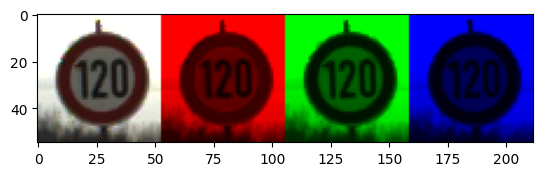

In [101]:
red_c = np.zeros(img.shape, dtype='uint8')
red_c[:,:,0] = img[:,:,0]
green_c = np.zeros(img.shape, dtype='uint8')
green_c[:,:,1] = img[:,:,1]
blue_c = np.zeros(img.shape, dtype='uint8')
blue_c[:,:,2] = img[:,:,2]
rgb_ims = cv2.hconcat([img, red_c, green_c, blue_c])
plt.imshow(rgb_ims)
plt.show()

In [153]:
def data_prep(path):
    original_image = np.asarray(torchvision.transforms.Resize((48,48))(Image.open(path)))

    imadjust = torchvision.transforms.Resize((48,48))(Image.open(path))
    imadjust = trans.adjust_contrast(imadjust, 2)
    constrast_image = np.asarray(imadjust)

    histeq = torchvision.transforms.Resize((48,48))(Image.open(path))
    histeq = trans.equalize(histeq)
    equalization_image = np.asarray(histeq)

    np_image = np.asarray(torchvision.transforms.Resize((48,48))(Image.open(path)))
    image = torch.from_numpy(np_image)
    image = image.swapaxes(1,2).swapaxes(0,1)

    assert image.shape[1] == image.shape[2], "Error in image transformation height and weight are not equal"

    iC, iH, iW = image.shape
    kH = kW = 6

    oH = oW = iW // kW

    for i in range(oH):
        for j in range(oW):
            image[:, i*kH:i*kH+kH, j*kW:j*kW+kW] = trans.equalize(image[:, i*kH:i*kH+kH, j*kW:j*kW+kW])

    adapt_eq_image = np.asarray(torchvision.transforms.ToPILImage()(image))

    gauss = torchvision.transforms.Resize((48,48))(Image.open(path))
    gauss = trans.gaussian_blur(gauss, kernel_size=[5,5], sigma=[1,1])
    conorm_image = np.asarray(gauss)

    data_images = cv2.hconcat([original_image, constrast_image, equalization_image, adapt_eq_image, conorm_image])

    plt.imshow(data_images)
    plt.show()


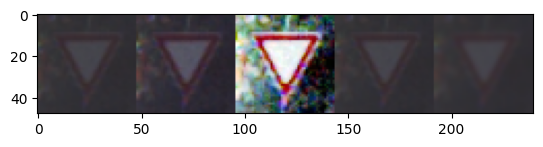

In [156]:
data_prep("data/val_images/00009/00013_00000_00012.ppm")

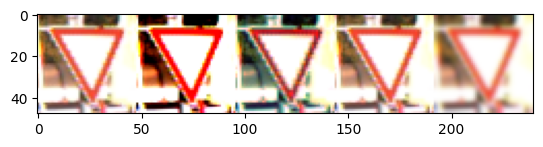

In [158]:
data_prep("data/val_images/00009/00013_00008_00013.ppm")

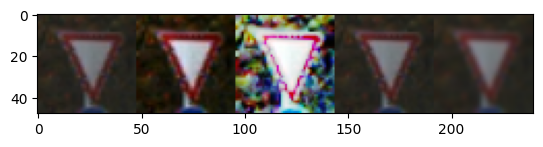

In [159]:
data_prep("data/val_images/00009/00013_00026_00001.ppm")

In [6]:
t1 = transforms.Compose([
    transforms.Resize((48,48)),
    Imadjust()
])

t2 = transforms.Compose([
    transforms.Resize((48, 48)),
    Histeq()
])

t3 = transforms.Compose([
    transforms.Resize((48, 48)),
    Adapthisteq()
])

t4 = transforms.Compose([
    transforms.Resize((48, 48)),
    Conorm()
])

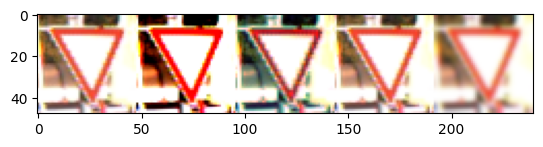

In [7]:
image_path = "data/val_images/00009/00013_00008_00013.ppm"

im = np.asarray(torchvision.transforms.Resize((48,48))(Image.open(image_path)))
im1 = np.asarray(t1(Image.open(image_path)))
im2 = np.asarray(t2(Image.open(image_path)))
im3 = np.asarray(t3(Image.open(image_path)))
im4 = np.asarray(t4(Image.open(image_path)))
plt.imshow(cv2.hconcat([im, im1, im2, im3, im4]))
plt.show()

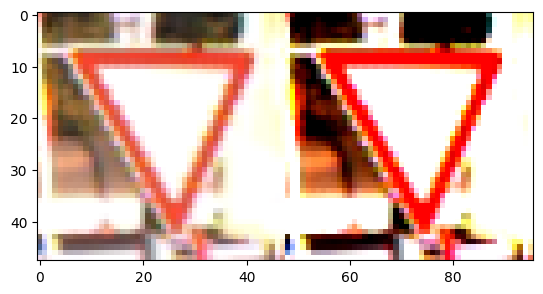

In [178]:
im1 = np.asarray(torchvision.transforms.Resize((48,48))(Image.open("data/val_images/00009/00013_00008_00013.ppm")))
im2 = np.asarray(Image.open("prova.ppm"))
plt.imshow(cv2.hconcat([im1, im2]))
plt.show()

In [187]:
Adapthisteq()

NameError: name 'Adapthisteq' is not defined